<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install alpaca_trade_api

Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [106]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [11]:
def train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index.iloc[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, testval_day

In [245]:
ticker = "TQQQ" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = 365 # Size of training set
val_day_int = 180 # Size of validation set
test_day_int = 180 # Size of test set
offset_day_int = 365 # Number of days to off set the training data
train, val, test, full, offset, complete, traintest_day, testval_day = train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

In [246]:
full

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2019-01-23 11:15:00-05:00,2019-01-23 11:15:00-05:00,42.4000,42.4800,41.99,42.0500,416231,42.174168
2019-01-23 11:20:00-05:00,2019-01-23 11:20:00-05:00,42.0686,42.0715,41.89,41.9099,476190,41.986925
2019-01-23 11:25:00-05:00,2019-01-23 11:25:00-05:00,41.9200,41.9900,41.79,41.9899,361840,41.893181
2019-01-23 11:30:00-05:00,2019-01-23 11:30:00-05:00,41.9900,42.1200,41.93,42.1082,159377,42.018446
2019-01-23 11:35:00-05:00,2019-01-23 11:35:00-05:00,42.0966,42.1500,41.91,41.9900,108961,42.014600
...,...,...,...,...,...,...,...
2021-01-14 19:35:00-05:00,2021-01-14 19:35:00-05:00,182.5000,182.5800,181.30,181.3000,8534,181.869915
2021-01-14 19:40:00-05:00,2021-01-14 19:40:00-05:00,181.5000,181.8100,181.33,181.8100,6692,181.519643
2021-01-14 19:45:00-05:00,2021-01-14 19:45:00-05:00,181.9000,182.0900,181.90,182.0000,3610,182.006660


In [247]:
print(f'Training Days: {train_day_int}, Set Start: {train.index[0].strftime("%d-%b-%Y")}, End: {train.index[-1].strftime("%d-%b-%Y")}, Shape: {train.shape}')
print(f'Validation Days: {val_day_int}, Set Start: {val.index[0].strftime("%d-%b-%Y")}, End: {val.index[-1].strftime("%d-%b-%Y")}, Shape: {val.shape}')
print(f'Testing Days: {test_day_int}, Start: {test.index[0].strftime("%d-%b-%Y")}, End: {test.index[-1].strftime("%d-%b-%Y")}, Shape: {test.shape}')

Training Days: 365, Set Start: 23-Jan-2019, End: 17-Jan-2020, Shape: (42245, 7)
Validation Days: 180, Set Start: 21-Jan-2020, End: 17-Jul-2020, Shape: (23528, 7)
Testing Days: 180, Start: 20-Jul-2020, End: 14-Jan-2021, Shape: (23087, 7)


In [248]:
print(f'Number of Rows Between all Sets: {(train.shape[0] + val.shape[0] + test.shape[0])}, Shape of Full Set: {full.shape[0]}')

Number of Rows Between all Sets: 88860, Shape of Full Set: 88860


# Loading and Preparing The Data

In [327]:
# create target from OHLC and Volume Data
def buildTargets(full_df = full, train_observations = train.shape[0], 
                 val_observations = val.shape[0], 
                 test_observations = test.shape[0], 
                 shift_2hour = 24,
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 252 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 25)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)

  #print(len(full_df.Close), len(volatility))

  targets = ["flat"] * len(full_df.Close)

  targets = np.where(full_df.Close.shift(-shift_2hour) >= (full_df.Close * (1 + alph * volatility)), 
           "up", targets)
  
  targets = np.where(full_df.Close.shift(-shift_2hour) <= (full_df.Close * (1 - alph * volatility)), 
           "down", targets)

  train_split = train_observations
  val_split = train_observations + val_observations
  test_split = train_observations + val_observations + test_observations

  train_targets = targets[:train_split]
  val_targets = targets[train_split:val_split]
  test_targets = targets[val_split:test_split]
  full_targets = targets

  return train_targets, val_targets, test_targets, full_targets

In [328]:
# print(buildTargets.__doc__)
train_targets, val_targets, test_targets, full_targets = buildTargets()

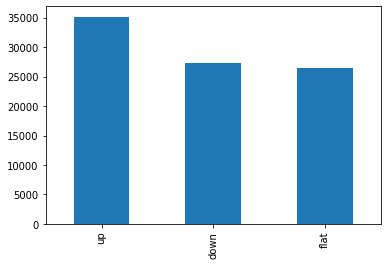

In [329]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

# APPENDIX

In [322]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])

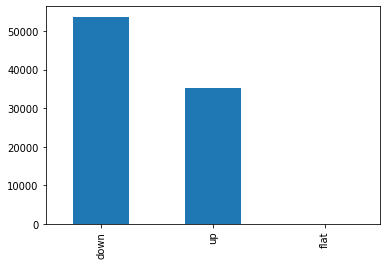

In [323]:
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

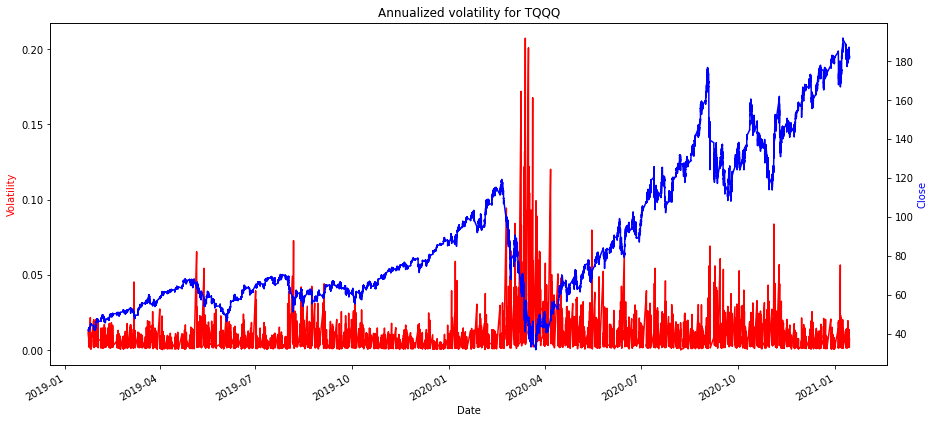

In [326]:
def buildTargets_VolOnly(full_df = full, train_observations = train.shape[0], 
                         val_observations = val.shape[0], 
                         test_observations = test.shape[0], 
                         alph = 0.55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
plt.show()

In [ ]:
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
full.drop(columns=['Time', ])

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data=load_breast_cancer(as_frame=True)

In [ ]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64